# Example of supervised learning using Phylomix augmentation

### Import required packages

In [1]:
import sys
sys.path.insert(1, '../src/')

from ete4 import Tree
from mixup import Mixup, PhylogenyTree, PhylogenyDataset
dataset = "ibd200"
target = "type"

data_fp = f'../data/{dataset}/data.tsv.xz'
meta_fp = f'../data/{dataset}/meta.tsv'
target_fp = f'../data/{dataset}/{target}.py'

phylogeny_tree_fp = '../data/WoL2/phylogeny.nwk'
tree = PhylogenyTree.init_from_nwk(phylogeny_tree_fp)
data = PhylogenyDataset.init_from_files(data_fp, meta_fp, target_fp)
print("number of leaves in the phylogeny tree: ", len(list(tree.ete_tree.leaves())))

number of leaves in the phylogeny tree:  15953


### Pruning the Phylogeny tree to make sure number of leaves is the same as number of features

In [2]:
data = PhylogenyDataset.init_from_files(data_fp, meta_fp, target_fp)
tree.prune(data.features)
print("number of leaves in the phylogeny tree after pruning: ", len(list(tree.ete_tree.leaves())))

number of leaves in the phylogeny tree after pruning:  5287


### Fit a logistic regression on the alzbiom dataset

In [3]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.preprocessing import label_binarize
import warnings
from sklearn.exceptions import ConvergenceWarning
data = PhylogenyDataset.init_from_files(data_fp, meta_fp, target_fp)
# Assuming X and y are your features and labels respectively
# Ignore convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
data.clr_transform()
X, y = data.X, data.y

# Initialize the logistic regression model
model = LogisticRegression()

# Initialize the KFold class with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=0)

# To store the AUROC and AUPRC for each fold
auroc_scores_none = []
auprc_scores_none = []

# Perform 5-fold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    

    model.fit(X_train, y_train)
    y_prob = model.predict(X_test)
    
    auroc = roc_auc_score(y_test, y_prob)
    auroc_scores_none.append(auroc)
    
    auprc = average_precision_score(y_test, y_prob)
    auprc_scores_none.append(auprc)

average_auroc = np.mean(auroc_scores_none)
average_auprc = np.mean(auprc_scores_none)

print(f'Average AUROC across 5 folds: {average_auroc}')
print(f'Average AUPRC across 5 folds: {average_auprc}')


Average AUROC across 5 folds: 0.6559709920656213
Average AUPRC across 5 folds: 0.7079474009934368


### Augment the dataset using Phylomix

In [4]:
def create_subset(data, indices, normalize=True, one_hot_encoding=True, clr=True):
    X_subset = data.X[indices]
    y_subset = data.y[indices]
    ids_subset = data.ids[indices]
    subset = PhylogenyDataset(X_subset, y_subset, ids_subset, data.features)

    for i, idx1 in enumerate(indices):
        for j, idx2 in enumerate(indices):
            subset.unifrac_distances_map[i, j] = data.unifrac_distances_map[idx1, idx2]

    if one_hot_encoding:
        subset.one_hot_encode()
    if normalize:
        subset.normalize()
    if clr:
        subset.clr_transform()
    return subset

In [5]:
from sklearn.linear_model import LinearRegression   
 # Initialize the KFold class
data = PhylogenyDataset.init_from_files(data_fp, meta_fp, target_fp)
# data.one_hot_encode()
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)
X, y = data.X, data.y
# Initialize lists to store AUROC and AUPRC scores
auroc_scores_phylomix = []
auprc_scores_phylomix = []

# Perform K-fold cross-validation
for train_index, test_index in kf.split(X):
    train_dataset = create_subset(data, train_index, normalize=False, clr=False)
    test_dataset = create_subset(data, test_index, normalize=False, clr=True)
    mixup = Mixup(train_dataset, taxonomy_tree=None, phylogeny_tree=tree)
    augmented_data_phylomix = mixup.mixup(num_samples = 3 * len(train_dataset.X), method='phylomix', alpha=2.0, tree='phylogeny')
    augmented_data_phylomix.clr_transform()

    model = LinearRegression()
    model.fit(augmented_data_phylomix.X, augmented_data_phylomix.y[:, 0])

    # Predict the first label
    y_pred_first =np.array(model.predict(test_dataset.X)).reshape(-1, 1)

    # Recover the second label as 1 - predicted first label
    y_pred_second = 1 - y_pred_first
    pred_logits = np.concatenate((y_pred_first, y_pred_second), axis=1)

    auroc = roc_auc_score(np.argmax(test_dataset.y, axis=1), np.argmax(pred_logits, axis=1))
    auprc = average_precision_score(np.argmax(test_dataset.y, axis=1), np.argmax(pred_logits, axis=1))

    auroc_scores_phylomix.append(auroc)
    auprc_scores_phylomix.append(auprc)

# Calculate the average AUROC and AUPRC across all folds
average_auroc = np.mean(auroc_scores_phylomix)
average_auprc = np.mean(auprc_scores_phylomix)

print(f'Average AUROC across {n_splits} folds: {average_auroc}')
print(f'Average AUPRC across {n_splits} folds: {average_auprc}')


Average AUROC across 5 folds: 0.6863691625226152
Average AUPRC across 5 folds: 0.7242234249448571


### Augment the dataset using compositional cutmix

In [6]:
from sklearn.linear_model import LinearRegression   
 # Initialize the KFold class
data = PhylogenyDataset.init_from_files(data_fp, meta_fp, target_fp)
n_splits = 5
# Initialize lists to store AUROC and AUPRC scores
auroc_scores_compositional = []
auprc_scores_compositional = []


# Fit a linear regression model to predict the first label (y[:, 0])
# Initialize the logistic regression model
model = LogisticRegression()

# Initialize the KFold class with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=0)

# Perform 5-fold cross-validation
for train_index, test_index in kf.split(X):
    train_dataset = create_subset(data, train_index, normalize=False, clr=True, one_hot_encoding=False)
    test_dataset = create_subset(data, test_index, normalize=False, clr=True, one_hot_encoding=False)
    X_train, y_train = train_dataset.X, train_dataset.y
    X_test, y_test = test_dataset.X, test_dataset.y
    mixup = Mixup(train_dataset, taxonomy_tree=None, phylogeny_tree=tree)
    augmented_data_compositional = mixup.compositional_cutmix(num_samples=3*len(X_train))

    model.fit(augmented_data_compositional.X, augmented_data_compositional.y)
    y_prob = model.predict(X_test)
    
    auroc = roc_auc_score(y_test, y_prob)
    auroc_scores_compositional.append(auroc)
    
    auprc = average_precision_score(y_test, y_prob)
    auprc_scores_compositional.append(auprc)

average_auroc = np.mean(auroc_scores_compositional)
average_auprc = np.mean(auprc_scores_compositional)

print(f'Average AUROC across 5 folds: {average_auroc}')
print(f'Average AUPRC across 5 folds: {average_auprc}')


Average AUROC across 5 folds: 0.6643043253989546
Average AUPRC across 5 folds: 0.7139308378464388


### Plot the AURPC and AUROC

In [7]:
import pandas as pd
# Get the data frame
augmentation_types = ['None'] * 5 + ['compositional_cutmix'] * 5 + ['phylomix'] * 5
auroc_scores = auroc_scores_none + auroc_scores_compositional + auprc_scores_phylomix
auprc_scores = auprc_scores_none + auprc_scores_compositional + auprc_scores_phylomix
model_type = ['linear'] * 15

# Create the DataFrame
data = {
    'Model Type': model_type,
    'Augmentation Type': augmentation_types,
    'test AUROC': auroc_scores,
    'test AUPRC': auprc_scores,
}

df = pd.DataFrame(data)

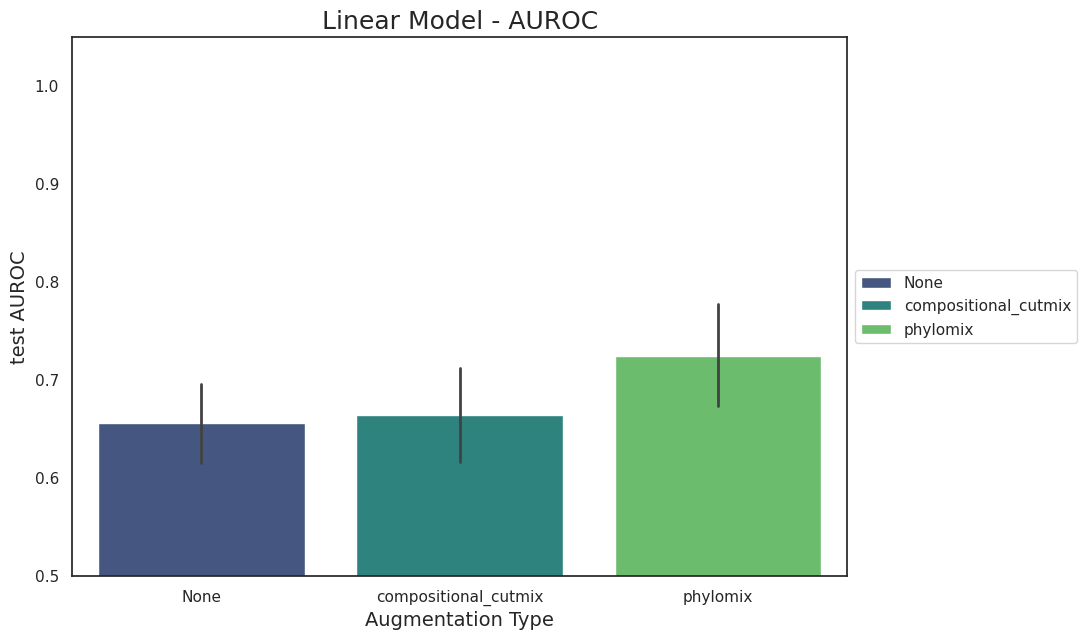

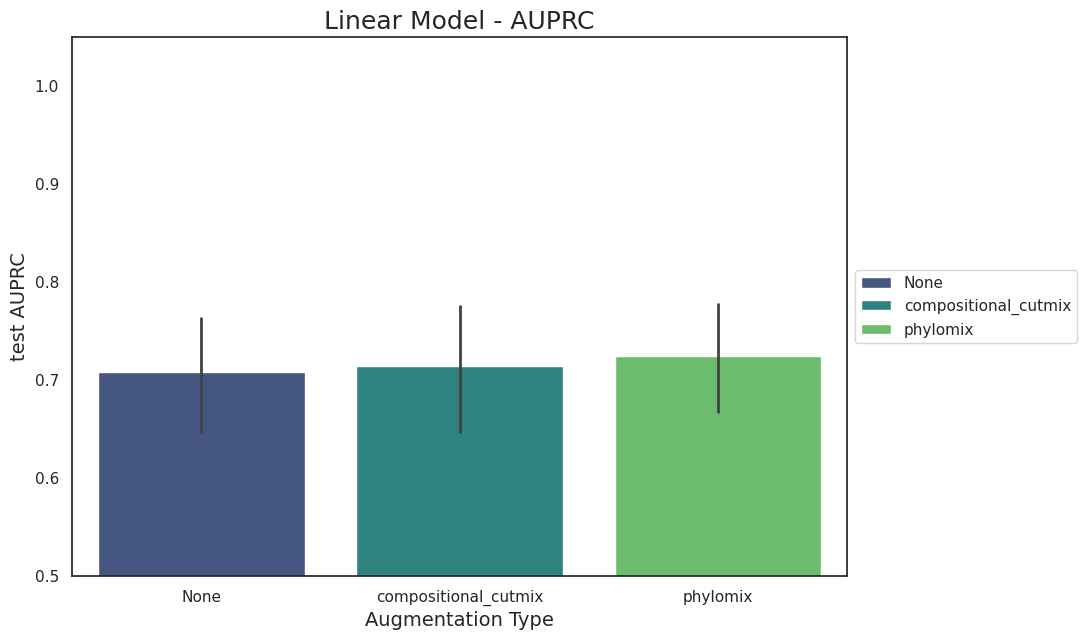

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statannotations.Annotator import Annotator
from statannotations.stats.StatTest import StatTest
import scipy.stats as stats

# Set the theme for the plot
sns.set_theme(style="white")

# Specify the metrics and model types
metrics = ['test AUROC', 'test AUPRC']
extra_type = ['None', 'compositional_cutmix', 'phylomix']

# Plotting each metric
for metric in metrics:
    plt.figure(figsize=(10, 7))
    ax = sns.barplot(
        data=df,
        x='Augmentation Type',
        order=extra_type,
        y=metric,
        hue='Augmentation Type',
        palette='viridis',  # You can use any palette or your custom palette here
        dodge=False,
        errwidth=2
    )

    plt.title(f'Linear Model - {metric.replace("test ", "")}', fontsize=18)
    plt.xlabel('Augmentation Type', fontsize=14)
    plt.ylabel(metric, fontsize=14)
    plt.ylim(0.5, 1.05)

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
